In [138]:
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
import os
import resampy

In [105]:
def load_data(data_path):
    data = []
    labels = []
    emotions = {'angry_05': 0, 'boredom': 1, 'calm_02': 2, 'disgust_07': 3, 'fearful_06': 4, 'happy_03': 5, 'neutral_01': 6, 'pain': 7, 'sad_04': 8, 'suprised_08': 9} # Duygulara göre etiketler
    for emotion in emotions.keys():
        emotion_path = os.path.join(data_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith('.wav'):
                filepath = os.path.join(emotion_path, filename)
                feature = extract_feature(filepath)
                data.append(feature)
                labels.append(emotions[emotion])
    return np.array(data), np.array(labels)

In [106]:
def extract_feature(file_path, n_mfcc=40, max_len=174):
    audio_data, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=n_mfcc)
    pad_width = max_len - mfccs.shape[1]
    if pad_width > 0:
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_len]
    #print(mfccs)
    return mfccs

In [107]:
data, labels = load_data('D:/yapayzekafinal/ses')
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


In [108]:
from keras.utils import to_categorical
print(y_train)
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)
print(y_train_encoded)


[9 6 2 ... 4 2 9]
[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [109]:
x_train.shape

(2671, 40, 174)

In [149]:
cnn_model = Sequential()

# Convolutional ve MaxPooling katmanları
cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(40, 174, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='sigmoid'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
# Tam bağlantılı (fully connected) katmanlar
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(64, activation='sigmoid'))

# Çıkış katmanı
cnn_model.add(Dense(10, activation='softmax'))  # 10 sınıf için çıkış

In [150]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [151]:
cnn_history = cnn_model.fit(x_train, y_train_encoded, batch_size=64, epochs=17, validation_data=(x_test, y_test_encoded))


Epoch 1/17
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 337ms/step - accuracy: 0.1890 - loss: 2.2943 - val_accuracy: 0.3204 - val_loss: 1.9788
Epoch 2/17
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - accuracy: 0.2987 - loss: 1.9642 - val_accuracy: 0.3338 - val_loss: 1.7927
Epoch 3/17
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 365ms/step - accuracy: 0.3238 - loss: 1.7924 - val_accuracy: 0.3593 - val_loss: 1.7043
Epoch 4/17
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 332ms/step - accuracy: 0.3647 - loss: 1.6767 - val_accuracy: 0.4012 - val_loss: 1.5639
Epoch 5/17
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 331ms/step - accuracy: 0.4219 - loss: 1.5347 - val_accuracy: 0.4461 - val_loss: 1.4614
Epoch 6/17
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 328ms/step - accuracy: 0.4718 - loss: 1.4442 - val_accuracy: 0.5000 - val_loss: 1.3533
Epoch 7/17
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 326ms/step - accuracy: 0.5228 - loss: 1.3232 - val_accuracy: 0.5704 - val_loss: 1.1870
Epoch 8/17
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 331ms/step - accuracy: 0.6300 - loss: 1.1258 - val_accu

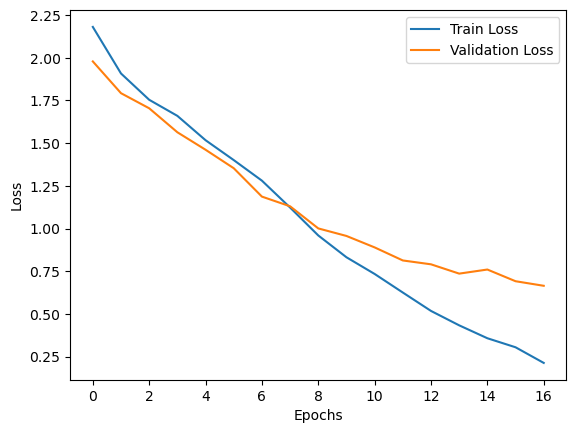

In [155]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [156]:
cnn_scores = cnn_model.evaluate(x_test, y_test_encoded, verbose=0)
print("CNN Model Accuracy: %.2f%%" % (cnn_scores[1]*100))

CNN Model Accuracy: 78.29%


In [157]:
cnn_y_pred = cnn_model.predict(x_test)
cnn_y_pred_labels = np.argmax(cnn_y_pred, axis=1)
print(classification_report(y_test, cnn_y_pred_labels))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        95
           1       0.82      0.84      0.83        63
           2       0.92      0.82      0.87        74
           3       0.68      0.62      0.65        37
           4       0.74      0.48      0.58        77
           5       0.66      0.76      0.70        83
           6       0.71      0.80      0.75        30
           7       0.91      0.89      0.90       114
           8       0.75      0.81      0.78        62
           9       0.66      0.88      0.75        33

    accuracy                           0.78       668
   macro avg       0.76      0.78      0.76       668
weighted avg       0.79      0.78      0.78       668



In [158]:
cnn_model.save('sesmodeli1.keras')